## Setup and Imports

In [ ]:
import sys
sys.path.append("/ML_CW2/TorchSSL")  

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json

from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# For clustering & neighbors
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from resnet_cifar import resnet18

In [39]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Load CIFAR-10 Dataset

 use random crop + horizontal flip + normalization for training augmentation, as recommended by Hacohen et al. (2022) in their fully supervised setting.

In [40]:
set_seed(42) 

# Download CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None  # returns PIL images
)

# Basic test transform (no random crop/flip for test data)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

testloader = DataLoader(testset, batch_size=256, shuffle=False)


## Define Models
# 
# 
##### - `create_resnet18_for_cifar` for a ResNet-18 classifier
##### - `SimCLRNet` for loading a pre-trained SimCLR backbone
##### - `LinearClassifier` for linear evaluation on embeddings

In [ ]:
def create_resnet18_for_cifar(num_classes=10):
    """
    Returns a ResNet-18 backbone 
    plus a final linear layer for classification.
    """
    backbone_dict = resnet18(in_channel=3)  
    backbone = backbone_dict['backbone']
    feature_dim = backbone_dict['dim']  # 512

    class ResNet18Classifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.backbone = backbone
            self.fc = nn.Linear(feature_dim, num_classes)

        def forward(self, x, return_features=False):
            feats = self.backbone(x)  # shape [bs, 512]
            logits = self.fc(feats)   # shape [bs, num_classes]
            if return_features:
                return logits, feats
            else:
                return logits

    return ResNet18Classifier()



In [ ]:
#from resnet_cifar import resnet18

class SimCLRNet(nn.Module):
    """
    A ResNet-18 backbone plus a contrastive head for pre-trained SimCLR.
    use for self-supervised embeddings.
    """
    def __init__(self):
        super().__init__()
        backbone_dict = resnet18(in_channel=3)
        self.backbone = backbone_dict['backbone']   
        backbone_dim  = backbone_dict['dim']       
        print("backbone done")

        self.contrastive_head = nn.Sequential(
            nn.Linear(backbone_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)

        )

    def forward(self, x, return_features=False):
        feats = self.backbone(x)          
        proj  = self.contrastive_head(feats) 
        if return_features:
            return proj, feats
        else:
            return proj


# Instantiate model
simclr_model = SimCLRNet ()  #features_dim=128

# Load  Pretrained SimCLR Model
checkpoint_path = 'simclr_cifar-10.pth/simclr_cifar-10.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')

new_state_dict = {}
for key, value in checkpoint.items():
    # Example logic: if your checkpoint has "backbone.xxx" keys,
    # and your model also calls it "backbone.xxx", then you may not need to rename.
    # If, however, your checkpoint calls it "encoder.xxx" but your code expects "backbone.xxx",
    # then do the rename here.

    if key.startswith("encoder."):
        # e.g., rename "encoder.layer1" -> "backbone.layer1"
        new_key = "backbone." + key[len("encoder."):]
    elif key.startswith("projector."):
        # rename "projector.fc" -> "contrastive_head.fc"
        new_key = "contrastive_head." + key[len("projector."):]
    else:
        new_key = key

    # Optionally fix 'shortcut' -> 'downsample'
    if "shortcut" in new_key:
        new_key = new_key.replace("shortcut", "downsample")

    new_state_dict[new_key] = value

# Place the checkpoint's model in eval mode
simclr_model.load_state_dict(new_state_dict, strict=False)  # or checkpoint['state_dict']
simclr_model.eval()
#print("model lpoaded")



backbone done


SimCLRNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [43]:
import torch
import torch.nn as nn

class LinearClassifier(nn.Module):
    """
    For linear evaluation on extracted embeddings.
    """
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        
        return self.linear(x)


## 4. Helper Functions
# 
#### This section includes:
##### - `extract_embeddings` for turning a subset of data into embedding vectors  
##### - `cluster_embeddings`, `compute_typicality_sklearn`, `select_typical_samples` for TPC(RP)  
##### - `query_selection` for the main AL selection logic  
##### - `evaluate` for evaluating a classifier


In [44]:
class TransformedSubset(Dataset):
    """
    A custom subset that can apply transforms on the fly.
    """
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]
        if self.transform is not None:
            img = self.transform(img)  
        return img, label

    def __len__(self):
        return len(self.indices)


def extract_embeddings(model, dataset, device='cpu', batch_size=256):
    """
    Convert PIL -> Tensor before passing to model.
    No random augmentations here, only basic normalization.
    """
    from torch.utils.data import DataLoader

    embedding_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
    ])

    indices = list(range(len(dataset)))

    transformed_subset = TransformedSubset(
        base_dataset=dataset,
        indices=indices,
        transform=embedding_transform
    )

    loader = DataLoader(transformed_subset, batch_size=batch_size, shuffle=False)

    all_feats = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            # forward pass
            _, feats = model(imgs, return_features=True)
            all_feats.append(feats.cpu().numpy())

    return np.concatenate(all_feats, axis=0)


This is the modification i implemented. Rather than calculating typicality using the inverse distance. I will be using Gaussian-based density, this smoothes out outliers and help focus more on most dense regions.
Use this function in place of compute_typicality_sklearn, when trying to test the modified version.

In [ ]:


def compute_gaussian_density(embeddings, k=20, alpha=0.2):
    """
    Computes a Gaussian-based density score for each point.
    For each point, we find its k nearest neighbors and
    sum exp(-alpha * d^2) for their distances d.

    Args:
      embeddings (np.ndarray): shape [N, D], N points in D-dim space
      k (int): number of neighbors to consider
      alpha (float): kernel width parameter

    Returns:
      scores (np.ndarray): shape [N], density score per point
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    # Distances: shape [N, k+1], indices: shape [N, k+1]
    dist, _ = nbrs.kneighbors(embeddings)
    
    # dist[i, 0] is the distance from point i to itself (0.0), so skip it
    # sum over neighbors 1..k
    dist_to_neighbors = dist[:, 1:]  # shape [N, k]

    # Gaussian kernel weights: exp(-alpha * d^2)
    # shape [N, k]
    weights = np.exp(-alpha * (dist_to_neighbors ** 2))

    # sum across the k neighbors for each point
    scores = weights.sum(axis=1)

    return scores


In [46]:

def cluster_embeddings(embeddings, n_clusters):
    """
    Runs K-means clustering on the embeddings, returning cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    print("Cluster distribution:", dict(zip(unique_clusters, counts)))

    return cluster_labels


In [ ]:
#from sklearn.neighbors import NearestNeighbors

def compute_typicality_sklearn(embeddings, k=20):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    dist, _ = nbrs.kneighbors(embeddings)
    avg_dist = dist[:, 1:].mean(axis=1)
    return 1.0 / (avg_dist + 1e-8)
#typicality_vals = compute_typicality_sklearn(embeddings, k=20)

In [48]:
def select_typical_samples(embeddings, cluster_labels, B, typicality_vals):
    """
    In each cluster, pick the point with the highest typicality.
    """
    chosen_indices = []
    for cluster_id in range(B):
        cluster_idx = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_idx) == 0:
            continue
        cluster_tvals = typicality_vals[cluster_idx]
        best_local_idx = cluster_idx[np.argmax(cluster_tvals)]
        chosen_indices.append(best_local_idx)
    return chosen_indices


The select_typical_samples2 is the modified method of selecting typical samples. replace with select_typical_samples when trying to run the modified version

In [49]:
def select_typical_samples2(embeddings, cluster_labels, B,scores):
    chosen_indices = []
    for cluster_id in range(B):
        cluster_idx = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_idx) == 0:
            continue
        best_local_idx = cluster_idx[np.argmax(scores[cluster_idx])]
        chosen_indices.append(best_local_idx)
    return chosen_indices



To enable the modified TPC(RP): comment out the lines using typicality_vals and local_chosen then uncomment the lines using scores = compute_gaussian_density(...) and local_chosen2 = select_typical_samples2(...)

In [71]:
def query_selection(
    selection_mode,      # "random" or "tpcrp"
    embedding_mode,      # "fullysupervised", "selfsupervised", "semisupervised"
    unlabeled_indices,
    dataset,
    device='cpu',
    classifier=None,
    simclr_model=None,
    B=10
):
    """
    Chooses B new points to label, using either random or TPC(RP).
    For TPC(RP), we compute embeddings, cluster, and pick typical points.

    NOTE : To implement the modified version, uncomment local_chosen2 and scores, then comment out local_chosen ans typicality_vals
    """
    if selection_mode == 'random':
        return list(np.random.choice(unlabeled_indices, size=B, replace=False))

    elif selection_mode == 'tpcrp':
        unlabeled_subset = Subset(dataset, unlabeled_indices)

        # Get embeddings
        if embedding_mode == 'fullysupervised':
            assert classifier is not None
            embeddings = extract_embeddings(classifier, unlabeled_subset, device=device)

        elif embedding_mode == 'selfsupervised':
            assert simclr_model is not None
            embeddings = extract_embeddings(simclr_model, unlabeled_subset, device=device)

        elif embedding_mode == 'semisupervised':
            assert classifier is not None
            embeddings = extract_embeddings(classifier, unlabeled_subset, device=device)

        else:
            raise ValueError(f"Unknown embedding_mode: {embedding_mode}")

        # Cluster
        cluster_labels = cluster_embeddings(embeddings, B)
        
        
        # Compute typicality using the paper's algorithm
        # Comment if you want to use modified version
        #typicality_vals = compute_typicality_sklearn(embeddings, k=20)
        #local_chosen = select_typical_samples(embeddings, cluster_labels, B, typicality_vals)
        # chosen_global = [unlabeled_indices[loc] for loc in local_chosen]
        
        # Uncomment if you want to use modified version
        scores = compute_gaussian_density(embeddings, k=20, alpha=0.2)
        local_chosen2 = select_typical_samples2(embeddings, cluster_labels, B, scores)

        # Convert local indices to global dataset indices
        chosen_global = [unlabeled_indices[loc] for loc in local_chosen2]
        return chosen_global

    else:
        raise ValueError(f"Unknown selection_mode: {selection_mode}")


In [51]:
def evaluate(model, test_loader, device='cpu'):
    """
    Evaluates model accuracy on the test set.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100.0 * correct / total

In [67]:
def train_linear_on_embeddings(
    simclr_model,       # Pretrained self-supervised model
    dataset,            # Full dataset (CIFAR-10)
    labeled_indices,    # Indices of labeled data
    embed_dim=512,      
    num_classes=10,
    epochs=100,
    lr= 2.5, #0.01, #2.5, 
    batch_size=64,
    device='cpu'
):
    # Build a subset of the labeled data
    labeled_subset = Subset(dataset, labeled_indices)
    labels = [dataset.targets[i] for i in labeled_indices]

    # Extract embeddings for labeled data
    embeddings = extract_embeddings(simclr_model, labeled_subset, device=device, batch_size=batch_size)
    embeddings_tensor = torch.from_numpy(embeddings).float()
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset for easy DataLoader usage
    labeled_dataset_embed = TensorDataset(embeddings_tensor, labels_tensor)
    loader = DataLoader(labeled_dataset_embed, batch_size=batch_size, shuffle=True)

    # Create a linear classifier
    linear_clf = LinearClassifier(embed_dim, num_classes).to(device)

    # Setup optimizer and loss
    optimizer = torch.optim.SGD(linear_clf.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    linear_clf.train()
    for ep in range(epochs):
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = linear_clf(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

    return linear_clf


 ### Evaluate Linear Classifier on Self-Supervised Embeddings

In [53]:
def evaluate_linear_on_embeddings(
    simclr_model,
    linear_clf,
    testset,
    batch_size=256,
    device='cpu'
):
    """
    Evaluates the performance of a linear classifier trained on self-supervised embeddings.

    Args:
      simclr_model: the pre-trained SimCLR model used for feature extraction
      linear_clf: a linear layer (classifier) trained on extracted embeddings
      testset: the test dataset (with transforms already applied if needed)
      batch_size: how many samples per batch during evaluation
      device: "cpu" 

    Returns:
      accuracy (%): the top-1 classification accuracy on the testset
    """
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    correct, total = 0, 0

    
    simclr_model.eval()
    linear_clf.eval()

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Extract features from simCLR model
            _, feats = simclr_model(imgs, return_features=True)

            # Classify these features using the linear layer
            logits = linear_clf(feats)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total


### Fully Supervised (Paper-Style) Training
# 
#### This function implements the training procedure described in the paper:
##### - SGD with momentum=0.9, Nesterov=True
##### - Cosine LR scheduler
##### - Random crop + horizontal flip for augmentation

In [54]:

import torch.optim as optim

def train_fully_supervised(
    model,
    dataset,
    labeled_indices,
    device='cpu',
    epochs=100,
    initial_lr=0.025,
    batch_size=64
):
    """
    Args:
      model: the neural network model to train
      dataset: the entire training dataset (unlabeled + labeled), from which labeled_indices is picked
      labeled_indices: which samples to use for supervised training
      device: "cpu" 
      epochs: total number of epochs to train
      initial_lr: the initial learning rate for SGD
      batch_size: mini-batch size

    Returns:
      model: the trained model after the specified epochs
    """
    # Augmentations: random crop and horizontal flip
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616]
        )
    ])
    
    # Create a small dataset that applies these transforms only to the labeled subset
    class LabeledDatasetWithAug(torch.utils.data.Dataset):
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
            self.transform = train_transform

        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            img, label = self.base_dataset[real_idx]
            # Apply augmentations
            img = self.transform(img)
            return img, label

        def __len__(self):
            return len(self.indices)

    labeled_dataset_aug = LabeledDatasetWithAug(dataset, labeled_indices)
    loader = DataLoader(labeled_dataset_aug, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        nesterov=True
    )
    # CosineAnnealingLR cycles the LR down to 0 over 'epochs' steps
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    model.to(device)
    model.train()

    for ep in range(epochs):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Step the LR scheduler after each epoch
        scheduler.step()
    
    return model


### Unlabeled Dataset (Weak & Strong Augmentations)
# 
#### For semi-supervised training, two augmentations are needed:
##### - Weak: e.g., random crop + flip
##### - Strong: e.g., extra color jitter


In [55]:
class UnlabeledDatasetWeakStrong(Dataset):
    """
    For unlabeled data, (x_weak, x_strong).
    
    Args:
      base_dataset: a dataset of unlabeled samples
      transform_weak: a transform for 'weak' augmentation
      transform_strong: a transform for 'strong' augmentation
    """
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        x_weak = self.transform_weak(img)
        x_strong = self.transform_strong(img)
        return x_weak, x_strong

    def __len__(self):
        return len(self.base_dataset)


### Labeled Dataset Wrapper
# 
##### `LabeledDataset` is similar, but each sample includes its real label. 

In [56]:
from torch.utils.data import Dataset
class LabeledDataset(Dataset):
    """
    A small wrapper to handle labeled subsets with optional transforms.
    """
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]  
        if self.transform is not None:
            img = self.transform(img)  
        return img, label

    def __len__(self):
        return len(self.indices)


### Augmentation Pipelines
# 
##### - `labeled_transform`: random crop + flip + normalize for the labeled set
##### - `weak_transform`: a milder augmentation
##### - `strong_transform`: includes additional color jitter


In [57]:
labeled_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])
#import torchvision.transforms as transforms

weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4,
                           saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])


In [58]:
import torch.nn.functional as F
import torch

def train_semisupervised_weak_strong(
    model,
    labeled_dataset,        
    unlabeled_weak_strong,  
    device='cpu',
    epochs=50,
    batch_size=64,
    lr=1e-3,
    unsup_weight=1.0,
    conf_threshold=0.70
):
    labeled_loader   = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_weak_strong, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.to(device)
    model.train()

    steps_per_epoch = min(len(labeled_loader), len(unlabeled_loader))

    for epoch in range(epochs):
        labeled_iter   = iter(labeled_loader)
        unlabeled_iter = iter(unlabeled_loader)

        for step in range(steps_per_epoch):
            # 1) Labeled batch
            x_l, y_l = next(labeled_iter, (None, None))
            x_l, y_l = x_l.to(device), y_l.to(device)

            # 2) Unlabeled batch => (x_weak, x_strong)
            x_weak, x_strong = next(unlabeled_iter, (None, None))
            x_weak, x_strong = x_weak.to(device), x_strong.to(device)

            # -- Forward pass on labeled batch
            logits_l = model(x_l)
            sup_loss = criterion(logits_l, y_l)

            # -- Forward pass on weakly augmented unlabeled
            with torch.no_grad():
                logits_weak = model(x_weak)
                probs_weak = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = probs_weak.max(dim=1)

            # Confidence mask
            mask = (max_probs >= conf_threshold).float()

            # -- Forward pass on strongly augmented unlabeled
            logits_strong = model(x_strong)
            unsup_loss = criterion(logits_strong, pseudo_labels)
            unsup_loss = (unsup_loss * mask).mean()

            # Combine
            loss = sup_loss + unsup_weight * unsup_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # (Optional) Evaluate each epoch, or print progress
        # e.g. print("Epoch:", epoch, "Sup loss:", sup_loss.item(), "Unsup loss:", unsup_loss.item())

    return model


### Active Learning Loop (Fully Supervised)
# 
#### This loop repeatedly:
##### 1) Trains a fresh model from scratch on the labeled set (paper-style).
##### 2) Evaluates on the test set.
##### 3) Queries the next B samples (random or TPC(RP)).


In [59]:
def active_learning_loop_fully_supervised(
    trainset,
    testloader,
    selection_mode,   #"random" or "tpcrp"
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
):
    """
    Each cycle:
      1) Pick new labeled samples (random or TPC(RP)).
      2) Train a fresh ResNet18 fully supervised.
      3) Evaluate.
    """
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices   = []

    # Initial pick is random
    init_selection = query_selection("random", None, unlabeled_indices, trainset, B=initial_B)
    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    accuracies = []

    for cycle in range(cycles):
        print(f"\n=== FullySupervised Cycle {cycle}, #Labeled={len(labeled_indices)} ===")

        # Train a fresh model as directed by the paper
        model = create_resnet18_for_cifar(num_classes=10)
        model = train_fully_supervised(
            model,
            dataset=trainset,
            labeled_indices=labeled_indices,
            device=device,
            epochs=100,
            initial_lr=0.025,
            batch_size=64
        )

        # Evaluate
        acc = evaluate(model, testloader, device=device)
        print(f"Cycle {cycle} Accuracy: {acc:.2f}%")
        accuracies.append(acc)

        # Query new B
        new_selection = query_selection(
            selection_mode,
            "fullysupervised",
            unlabeled_indices,
            trainset,
            device=device,
            classifier=model,  # if using TPC(RP)
            B=cycle_B
        )
        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    return accuracies


### Active Learning Loop: Self-Supervised
# 
#### The function below implements a self-supervised active learning loop.
##### 1. `simclr_model` to embed unlabeled samples, and then pick points using TPC(RP) or random selection.
##### 2. After labeling those points, we train a linear classifier (`train_linear_on_embeddings`) on top of the SimCLR embeddings.
##### 3. We evaluate the linear classifier with `evaluate_linear_on_embeddings`.
##### 4. repeat for multiple cycles.

In [68]:
def active_learning_loop_self_supervised(
    trainset,
    testloader,
    selection_mode,
    simclr_model,    # pre-trained SimCLR model
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
):
    """
    1) Use simclr_model for TPC(RP) queries.
    2) Train a fresh ResNet18Classifier on the labeled set.
    3) Evaluate each cycle.
    """

    # Unlabeled pool initially includes all training indices
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices   = []

    # Initial pick using TPC(RP) + selfsupervised
    init_selection = query_selection(
        selection_mode,
        "selfsupervised",
        unlabeled_indices,
        trainset,
        device=device,
        simclr_model=simclr_model,
        B=initial_B
    )
    # Move them from unlabeled to labeled
    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    accuracies = []

    # Active Learning cycles
    for cycle in range(cycles):
        print(f"\n=== SelfSupervised AL Cycle {cycle}, #Labeled={len(labeled_indices)} ===")

        # Train a linear classifier on the embeddings of the labeled set
        linear_clf = train_linear_on_embeddings(
            simclr_model=simclr_model,
            dataset=trainset,
            labeled_indices=labeled_indices,
            embed_dim=512,   
            num_classes=10,
            epochs=100,
            lr= 2.5, #0.01,      #2.5
            batch_size=64,
            device='cpu'
        )

        # Evaluate the linear classifier
        acc = evaluate_linear_on_embeddings(
            simclr_model=simclr_model,
            linear_clf=linear_clf,
            testset=testset,
            batch_size=64,
            device='cpu'
        )
        print(f"Test Accuracy: {acc:.2f}%")
        accuracies.append(acc)

        # Acquire more labels
        # Next selection using simclr_model
        new_selection = query_selection(
            selection_mode,
            "selfsupervised",
            unlabeled_indices,
            trainset,
            device=device,
            simclr_model=simclr_model,
            B=cycle_B
        )
        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    return accuracies

### Class-Balanced Random Selection
# 
##### This function picks exactly one example from each class. 


In [61]:
def class_balanced_random_selection(trainset, num_classes=10):
    """
    Selects 1 example per class (class-balanced random selection).
    Returns a list of indices.
    """
    labeled_indices = []
    for class_id in range(num_classes):
        # Get all indices for the current class
        class_indices = [idx for idx, label in enumerate(trainset.targets) if label == class_id]
        # Randomly select 1 index for the current class
        selected_idx = np.random.choice(class_indices, size=1, replace=False)[0]
        labeled_indices.append(selected_idx)
    return labeled_indices

### Fixed-Budget Semi-Supervised Experiment
# 
##### A single-shot approach (rather than iterative) where we pick `B` samples,
##### train once in a semi-supervised manner, and evaluate. Repeat this for multiple seeds to measure variance.


In [62]:
def fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode,
    model_fn,
    simclr_model=None,
    B=10,
    seeds=[0, 1, 2],
    device='cpu'
):
    accuracies = []

    for seed in seeds:
        set_seed(seed)

        # Select B labeled samples
        if selection_mode == 'random':
            labeled_indices = query_selection(
                selection_mode='random',
                embedding_mode=None,
                unlabeled_indices=list(range(len(trainset))),
                dataset=trainset,
                device=device,
                B=B
            )
        elif selection_mode == 'tpcrp':
            labeled_indices = query_selection(
                selection_mode='tpcrp',
                embedding_mode='selfsupervised',
                unlabeled_indices=list(range(len(trainset))),
                dataset=trainset,
                device=device,
                simclr_model=simclr_model,
                B=B
            )
        elif selection_mode == 'Balanced_random':
            # Use class-balanced random selection
            labeled_indices = class_balanced_random_selection(trainset)
        else:
            raise ValueError(f"Unknown selection_mode: {selection_mode}")

        # Build labeled dataset
        labeled_dataset = LabeledDataset(
            base_dataset=trainset,
            indices=labeled_indices,
            transform=labeled_transform
        )

        # Build unlabeled dataset with strong and weak
        unlabeled_subset = Subset(trainset, [idx for idx in range(len(trainset)) if idx not in labeled_indices])
        unlabeled_ws = UnlabeledDatasetWeakStrong(
            unlabeled_subset,
            weak_transform,
            strong_transform
        )

        # Train in a semi-supervised manner
        model = model_fn(num_classes=10)
        model = train_semisupervised_weak_strong(
            model,
            labeled_dataset=labeled_dataset,
            unlabeled_weak_strong=unlabeled_ws,
            device=device,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            unsup_weight=1.0,
            conf_threshold=0.70
        )

        # Evaluate 
        acc = evaluate(model, testloader, device=device)
        accuracies.append(acc)

    # Compute mean and std of accuracies
    mean_acc = float(np.mean(accuracies))
    std_acc = float(np.std(accuracies))
    return mean_acc, std_acc

#### Example Usage of Fixed-Budget Semi-Supervised 
##### Below, run the fixed-budget experiment with "Balanced_random" for a single shot,
##### repeated over seeds [0,1,2]. Then do the same for "random" and "tpcrp".


In [26]:
# Run for class-balanced random baseline
mean_acc_class_balanced, std_acc_class_balanced = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='Balanced_random',
    model_fn=create_resnet18_for_cifar,
    simclr_model=None,  # Not needed for class-balanced random
    B=10,  # Not used for class-balanced random
    seeds=[0, 1, 2],
    device='cpu'
)
print(f"Class-Balanced Random => Mean Accuracy: {mean_acc_class_balanced:.2f} ± {std_acc_class_balanced:.2f}")

Class-Balanced Random => Mean Accuracy: 13.61 ± 6.22


In [ ]:
mean_acc_random, std_acc_random = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='random',
    model_fn=create_resnet18_for_cifar,
    simclr_model=None,  # pre-trained model
    B=10,
    seeds=[0,1,2],
    device='cpu'
)
print(f"Random => {mean_acc_random:.2f} ± {std_acc_random:.2f}")

Random => 13.48 ± 0.69


In [28]:
import time
mean_acc_tpcrp, std_acc_tpcrp = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='tpcrp',
    model_fn=create_resnet18_for_cifar,
    simclr_model=simclr_model,  # pre-trained model
    B=10,
    seeds=[0,1,2],
    device='cpu'
)
print(f"TPC(RP) => {mean_acc_tpcrp:.2f} ± {std_acc_tpcrp:.2f}")
#time.time()

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
TPC(RP) => 14.00 ± 1.06


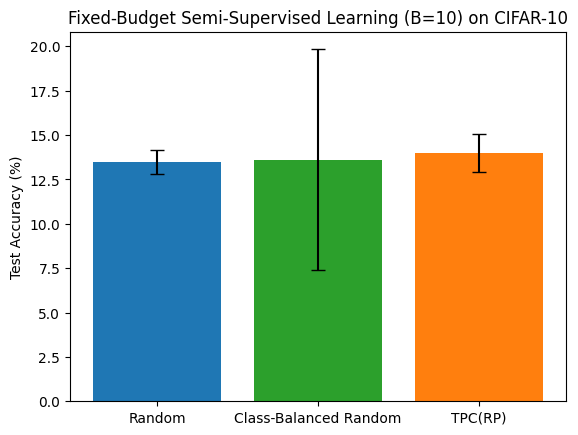

In [29]:
import matplotlib.pyplot as plt

methods = ["Random", "Class-Balanced Random", "TPC(RP)"]
means = [mean_acc_random, mean_acc_class_balanced, mean_acc_tpcrp]
stds  = [std_acc_random,  std_acc_class_balanced,  std_acc_tpcrp]

colors = ["tab:blue", "tab:green", "tab:orange"]

plt.bar(methods, means, yerr=stds, capsize=5, color=colors)
plt.ylabel("Test Accuracy (%)")
plt.title("Fixed-Budget Semi-Supervised Learning (B=10) on CIFAR-10")
plt.show()


In [30]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_budget(accs_random, accs_tpcrp, title="Fully Supervised Accuracy"):
    """
    accs_random: list of accuracy per cycle for 'random' approach
    accs_tpcrp:  list of accuracy per cycle for 'tpcrp' approach
    title: plot title
    """
    # xvals are just 0..(len(accs_random)-1)
    xvals = range(len(accs_random))  
    # Each cycle adds 10 new samples, plus the initial 10 at cycle=0 = total_labeled = 10*(i+1)
    budgets = [10*(i+1) for i in xvals]  

    plt.figure()
    plt.plot(xvals, accs_random, marker='o', color='green', label='Random')
    plt.plot(xvals, accs_tpcrp, marker='o', color='orange', label='TPC(RP)')

    # Rename the ticks to show the budgets
    plt.xticks(ticks=xvals, labels=budgets)
    plt.xlabel("Budget (labelled examples)")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.show()

Running with no seed set (non-deterministic)

=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 14.60%

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 19.12%

=== FullySupervised Cycle 2, #Labeled=30 ===
Cycle 2 Accuracy: 17.61%

=== FullySupervised Cycle 3, #Labeled=40 ===
Cycle 3 Accuracy: 20.10%

=== FullySupervised Cycle 4, #Labeled=50 ===
Cycle 4 Accuracy: 21.64%

=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 16.51%
Cluster distribution: {np.int32(0): np.int64(11119), np.int32(1): np.int64(2853), np.int32(2): np.int64(10524), np.int32(3): np.int64(1260), np.int32(4): np.int64(1992), np.int32(5): np.int64(4132), np.int32(6): np.int64(6058), np.int32(7): np.int64(4286), np.int32(8): np.int64(5154), np.int32(9): np.int64(2612)}

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 17.34%
Cluster distribution: {np.int32(0): np.int64(7321), np.int32(1): np.int64(3218), np.int32(2): np.int64(8970), np.int32(3): np.int64(4388), np.i

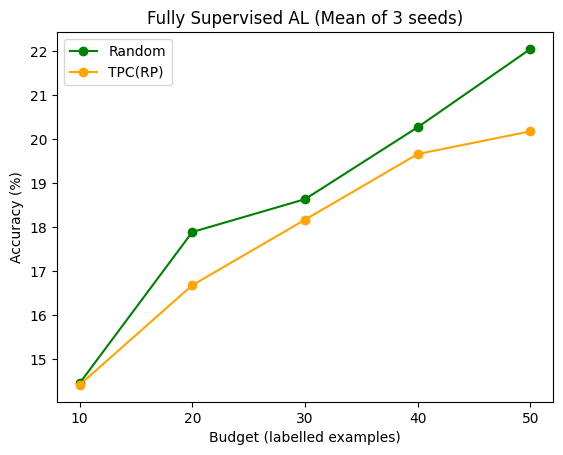

In [32]:
import numpy as np

all_runs_random = []
all_runs_tpcrp = []

for s in [None, 0, 100]:
    if s is not None:
        set_seed(s)
        print(f"Running with seed={s}")
    else:
        print("Running with no seed set (non-deterministic)")

    #set_seed(s)
    accs_rm = active_learning_loop_fully_supervised(trainset, testloader, selection_mode="random", initial_B=10, cycle_B=10, cycles=5)
    accs_tp = active_learning_loop_fully_supervised(trainset, testloader, selection_mode="tpcrp", initial_B=10, cycle_B=10, cycles=5)
    all_runs_random.append(accs_rm)
    all_runs_tpcrp.append(accs_tp)

# Convert to numpy arrays of shape [num_seeds, cycle]
all_runs_random = np.array(all_runs_random)
all_runs_tpcrp  = np.array(all_runs_tpcrp)

# Take the mean (and std) across seeds = shape [cycles]
mean_random = all_runs_random.mean(axis=0)
std_random  = all_runs_random.std(axis=0)
mean_tpcrp  = all_runs_tpcrp.mean(axis=0)
std_tpcrp   = all_runs_tpcrp.std(axis=0)

# Plot the averaged curves
plot_accuracy_vs_budget(mean_random, mean_tpcrp, title="Fully Supervised AL (Mean of 3 seeds)")


### Below, shows two learning-rate scenarios (2.5 vs. 0.01) for self-supervised AL. Users can modify the LR in the code cells if they wish to explore other values.

In [39]:
#set_seed(42)
accs_self_rand_lr01= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='random',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random:", accs_self_rand_lr01)


=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 29.67%

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 32.25%

=== SelfSupervised AL Cycle 2, #Labeled=30 ===
Test Accuracy: 42.96%

=== SelfSupervised AL Cycle 3, #Labeled=40 ===
Test Accuracy: 41.15%

=== SelfSupervised AL Cycle 4, #Labeled=50 ===
Test Accuracy: 47.73%
Self-Supervised Random: [29.67, 32.25, 42.96, 41.15, 47.73]


In [34]:
accs_self_tpcrp_lr01= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp:", accs_self_tpcrp_lr01)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 33.82%
Cluster distribution: {np.int32(0): np.int64(8827), np.int32(1): np.int64(5164), np.int32(2): np.int64(1735), np.int32(3): np.int64(18881), np.int32(4): np.int64(3904), np.int32(5): np.int64(2990), np.int32(6): np.int64(2765), np.int32(7): np.int64(1315), np.int32(8): np.int64(3058), np.int32(9): np.int64(1351)}

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 41.34%
Cluster distribution: {np.int32(0): np.int64(3329), np.int32(1): np.int64(1282), np.int32(2): np.int64(1321), np.int32(3): np.int64(9783), np.int32(4): np.int64(3952), np.int32(5): np.int64(2881), np.int32(6): np.int64(166), np.int3

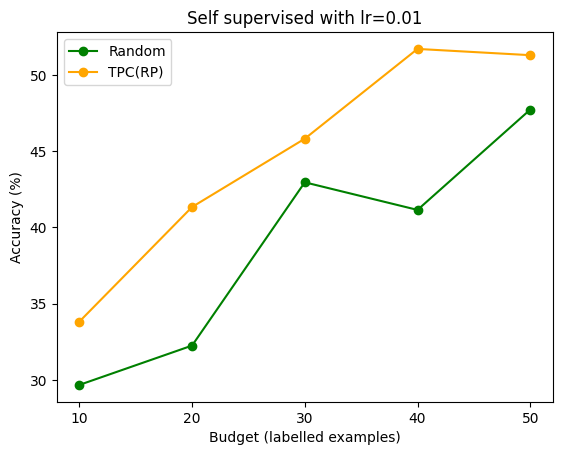

In [40]:
plot_accuracy_vs_budget(accs_self_rand_lr01, accs_self_tpcrp_lr01, "Self supervised with lr=0.01")

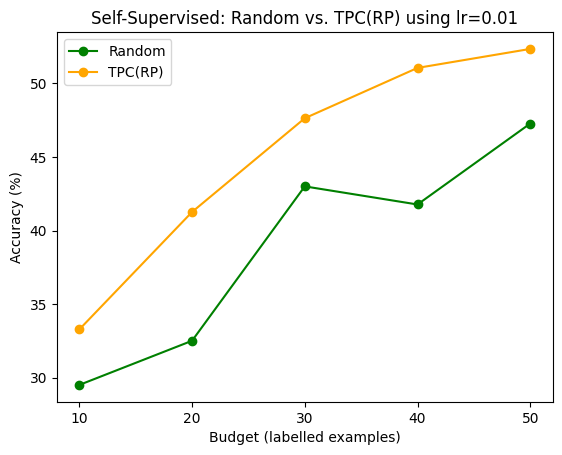

In [ ]:
#plot_accuracy_vs_budget(accs_self_ran_lr10, accs_self_tpcrp_lr10, 
 #                       title="Self-Supervised: Random vs. TPC(RP) using lr=0.01")

In [ ]:
#set_seed(42)
accs_self_rand= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='random',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random lr2.5:", accs_self_rand)


=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 36.78%

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 46.10%

=== SelfSupervised AL Cycle 2, #Labeled=30 ===
Test Accuracy: 64.18%

=== SelfSupervised AL Cycle 3, #Labeled=40 ===
Test Accuracy: 66.30%

=== SelfSupervised AL Cycle 4, #Labeled=50 ===
Test Accuracy: 67.43%
Self-Supervised Random: [36.78, 46.1, 64.18, 66.3, 67.43]


In [ ]:
#set_seed(42)
accs_self_tpcrp= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp lr2.5:", accs_self_tpcrp)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 40.49%
Cluster distribution: {np.int32(0): np.int64(8827), np.int32(1): np.int64(5164), np.int32(2): np.int64(1735), np.int32(3): np.int64(18881), np.int32(4): np.int64(3904), np.int32(5): np.int64(2990), np.int32(6): np.int64(2765), np.int32(7): np.int64(1315), np.int32(8): np.int64(3058), np.int32(9): np.int64(1351)}

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 41.52%
Cluster distribution: {np.int32(0): np.int64(3329), np.int32(1): np.int64(1282), np.int32(2): np.int64(1321), np.int32(3): np.int64(9783), np.int32(4): np.int64(3952), np.int32(5): np.int64(2881), np.int32(6): np.int64(166), np.int3

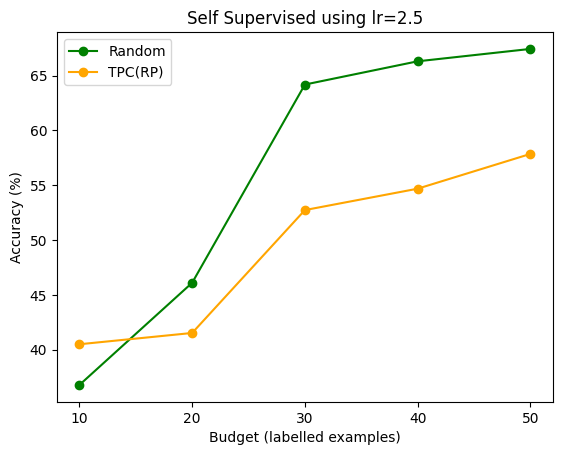

In [52]:
plot_accuracy_vs_budget(accs_self_rand, accs_self_tpcrp, "Self Supervised using lr=2.5")

In [73]:
set_seed(42)
accs_full_tpcrp_mod= active_learning_loop_fully_supervised(
    trainset, testloader, selection_mode='tpcrp',
    #simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Fully-Supervised tpcrp modified:", accs_full_tpcrp_mod)


=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 19.10%
Cluster distribution: {np.int32(0): np.int64(9000), np.int32(1): np.int64(468), np.int32(2): np.int64(2198), np.int32(3): np.int64(2197), np.int32(4): np.int64(9456), np.int32(5): np.int64(10203), np.int32(6): np.int64(6380), np.int32(7): np.int64(3909), np.int32(8): np.int64(4931), np.int32(9): np.int64(1248)}

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 19.76%
Cluster distribution: {np.int32(0): np.int64(7432), np.int32(1): np.int64(3644), np.int32(2): np.int64(1322), np.int32(3): np.int64(7994), np.int32(4): np.int64(2000), np.int32(5): np.int64(3595), np.int32(6): np.int64(337), np.int32(7): np.int64(7967), np.int32(8): np.int64(2783), np.int32(9): np.int64(12906)}

=== FullySupervised Cycle 2, #Labeled=30 ===
Cycle 2 Accuracy: 21.83%
Cluster distribution: {np.int32(0): np.int64(1526), np.int32(1): np.int64(7397), np.int32(2): np.int64(1046), np.int32(3): np.int64(8643), np.int32(4): np.int64(

In [78]:
set_seed(0)
accs_full_tpcrp_mod_s0= active_learning_loop_fully_supervised(
    trainset, testloader, selection_mode='tpcrp',
    #simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Fully-Supervised tpcrp modified:", accs_full_tpcrp_mod_s0)


=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 13.97%
Cluster distribution: {np.int32(0): np.int64(5267), np.int32(1): np.int64(2763), np.int32(2): np.int64(4179), np.int32(3): np.int64(4730), np.int32(4): np.int64(1318), np.int32(5): np.int64(1499), np.int32(6): np.int64(5188), np.int32(7): np.int64(12185), np.int32(8): np.int64(10620), np.int32(9): np.int64(2241)}

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 17.09%
Cluster distribution: {np.int32(0): np.int64(5248), np.int32(1): np.int64(4007), np.int32(2): np.int64(6771), np.int32(3): np.int64(1906), np.int32(4): np.int64(3387), np.int32(5): np.int64(8188), np.int32(6): np.int64(2302), np.int32(7): np.int64(575), np.int32(8): np.int64(10432), np.int32(9): np.int64(7164)}

=== FullySupervised Cycle 2, #Labeled=30 ===
Cycle 2 Accuracy: 17.58%
Cluster distribution: {np.int32(0): np.int64(7968), np.int32(1): np.int64(7779), np.int32(2): np.int64(2389), np.int32(3): np.int64(6812), np.int32(4): np.int6

In [72]:
set_seed(42)
accs_self_tpcrp_mod2_5= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp:", accs_self_tpcrp_mod2_5)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 41.44%
Cluster distribution: {np.int32(0): np.int64(3898), np.int32(1): np.int64(2990), np.int32(2): np.int64(2749), np.int32(3): np.int64(1967), np.int32(4): np.int64(1735), np.int32(5): np.int64(2754), np.int32(6): np.int64(18728), np.int32(7): np.int64(5141), np.int32(8): np.int64(8677), np.int32(9): np.int64(1351)}

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 42.32%
Cluster distribution: {np.int32(0): np.int64(9782), np.int32(1): np.int64(2768), np.int32(2): np.int64(4012), np.int32(3): np.int64(900), np.int32(4): np.int64(1546), np.int32(5): np.int64(4775), np.int32(6): np.int64(19466), np.int

In [ ]:
set_seed(100)
accs_self_rand_100= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='random',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random:", accs_self_rand_100)


=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 36.31%

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 46.32%

=== SelfSupervised AL Cycle 2, #Labeled=30 ===
Test Accuracy: 51.53%

=== SelfSupervised AL Cycle 3, #Labeled=40 ===
Test Accuracy: 58.71%

=== SelfSupervised AL Cycle 4, #Labeled=50 ===
Test Accuracy: 62.95%
Self-Supervised Random: [36.32, 45.83, 64.65, 66.13, 67.27]


In [ ]:
set_seed(100)
accs_self_tpcrp_100= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random:", accs_self_tpcrp_100)

In [75]:
accs_self_tpcrp=[40.49, 41.52, 52.73, 54.68, 57.85]

In [76]:
print(accs_self_tpcrp)

[40.49, 41.52, 52.73, 54.68, 57.85]


C:\Users\chaso\AppData\Local\Temp\ipykernel_3148\2398580661.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


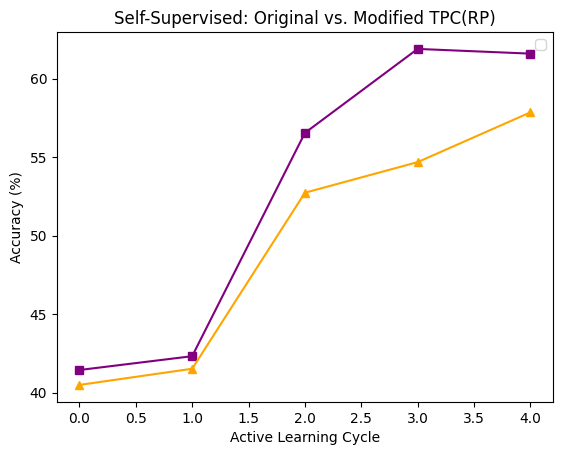

In [ ]:
plt.figure()
plt.plot(range(len(accs_self_tpcrp_mod2_5)), accs_self_tpcrp_mod2_5, marker='s', color='purple')
plt.plot(range(len(accs_self_tpcrp)), accs_self_tpcrp, marker='^', color='orange')
plt.xlabel("Active Learning Cycle")
plt.ylabel("Accuracy (%)")
plt.title("Self-Supervised: Original vs. Modified TPC(RP)")
#plt.legend()
plt.show()


In [80]:
accs_full_tpcrp_s0=[11.75, 16.28, 16.60, 19.87, 21.48]

In [81]:
print(accs_full_tpcrp_s0)

[11.75, 16.28, 16.6, 19.87, 21.48]


C:\Users\chaso\AppData\Local\Temp\ipykernel_3148\929087266.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


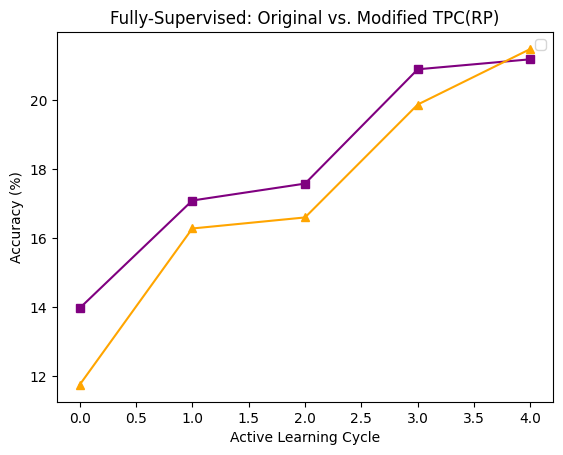

In [ ]:
plt.figure()
plt.plot(range(len(accs_full_tpcrp_mod_s0)), accs_full_tpcrp_mod_s0, marker='s', color='purple')
plt.plot(range(len(accs_full_tpcrp_s0)), accs_full_tpcrp_s0, marker='^', color='orange')
plt.xlabel("Active Learning Cycle")
plt.ylabel("Accuracy (%)")
plt.title("Fully-Supervised: Original vs. Modified TPC(RP)")
#plt.legend()
plt.show()


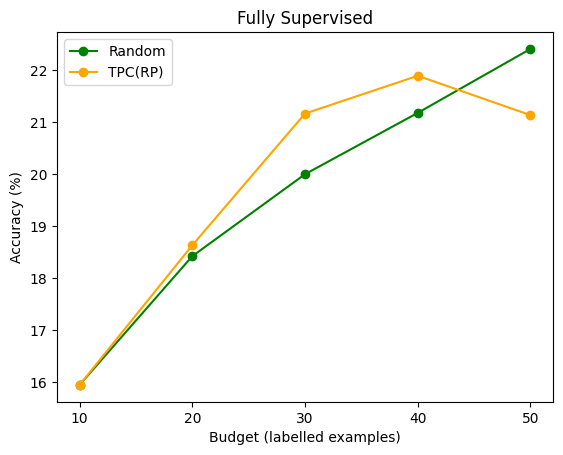

In [ ]:
#plot_accuracy_vs_budget(mean_accs_rm, mean_accs, 'Fully Supervised')

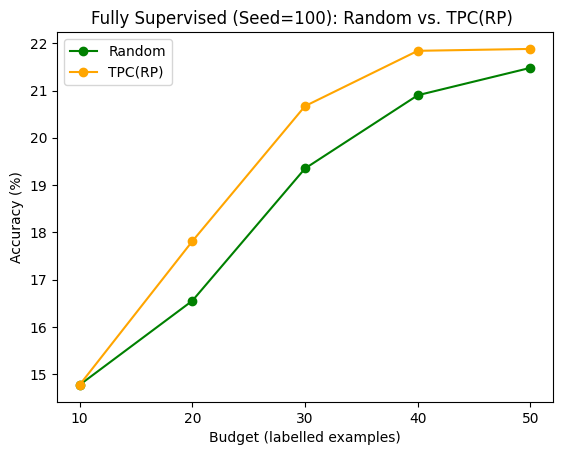

In [ ]:
#plot_accuracy_vs_budget(accs_fully_rm100, accs_fully_tr100, 
 #                       title="Fully Supervised (Seed=100): Random vs. TPC(RP) ")


In [ ]:
# Two-sample t-test for TPC(RP) vs. Random
import numpy as np
from scipy.stats import ttest_ind

acc_tpcrp = [ 45.2, 48.7, 47.3 ]   
acc_random = [ 44.9, 49.1, 46.5 ]  

# Perform a two-sample t-test
stat, p_value = ttest_ind(acc_tpcrp, acc_random, equal_var=True)

print("TPC(RP) accuracies:", acc_tpcrp)
print("Random accuracies:", acc_random)
print("t-statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("p < 0.05 => The difference is statistically significant.")
else:
    print("p >= 0.05 => No statistically significant difference.")


TPC(RP) accuracies: [45.2, 48.7, 47.3]
Random accuracies: [44.9, 49.1, 46.5]
t-statistic: 0.14663102735578384
p-value: 0.8905165688732657
p >= 0.05 => No statistically significant difference.
